In [2]:
# จัดการข้อมูล
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model
import xgboost as xgb
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import math

In [3]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

date      time cash_type          coffee_name  money
0 2023-03-01  08:04:19      card                Latte     75
1 2023-03-01  08:08:54      cash  Americano with Milk     70
2 2023-03-01  08:09:03      card           Cappuccino     75
3 2023-03-01  08:10:26      cash           Cappuccino     75
4 2023-03-01  08:15:37      cash           Cappuccino     75

In [4]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)

In [5]:

daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
display(daily_item_counts.head(10))

date          coffee_name  count
0 2023-03-01            Americano     19
1 2023-03-01  Americano with Milk     27
2 2023-03-01           Cappuccino     24
3 2023-03-01                Cocoa      7
4 2023-03-01              Cortado     14
5 2023-03-01             Espresso      6
6 2023-03-01        Hot Chocolate      4
7 2023-03-01                Latte     24
8 2023-03-02            Americano     19
9 2023-03-02  Americano with Milk     26

In [8]:
def create_item_features(df):
    # date เป็น datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.set_index('date', inplace=True)

    # Feature จากวันเวลา
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year

    # Lag และ Rolling
    df.sort_index(inplace=True)
    df['lag_7'] = df['count'].shift(7)
    df['lag_14'] = df['count'].shift(14)
    df['rolling_mean_7'] = df['count'].shift(1).rolling(window=7).mean()
    #lag_7 → จำนวน count ของ 7 วันก่อนหน้า
    #lag_14 → จำนวน count ของ 14 วันก่อนหน้า
    #rolling_mean_7 → ค่าเฉลี่ยย้อนหลัง 7 วัน (shift 1 เพื่อไม่ให้รวมวันปัจจุบัน)

    df.reset_index(inplace=True)
    return df

In [9]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'count'

# Dictionary เก็บผลลัพธ์
future_preds = {}

# วันที่แบ่ง Train/Test
split_date = '2025-01-01'

In [10]:
for coffee in daily_item_counts['coffee_name'].unique():
    print(f"\n===== Training model for: {coffee} =====")

    # เลือกเฉพาะเมนู
    coffee_data = daily_item_counts[daily_item_counts['coffee_name'] == coffee].copy()
    coffee_features = create_item_features(coffee_data)
    coffee_features.dropna(inplace=True)

    X = coffee_features[FEATURES]
    y = coffee_features[TARGET]

    # Train/Test Split ตามเวลา
    coffee_features['date'] = pd.to_datetime(coffee_features['date'])
    train = coffee_features[coffee_features['date'] < split_date]
    test = coffee_features[coffee_features['date'] >= split_date]

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    # สร้าง Model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # ประเมิน Model เบื้องต้น
    if len(X_test) > 0:
        preds_test = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds_test)
        print(f"MAE on Test Set: {mae:.2f}")

    # Forecast อนาคต (recursive lag)
    last_vals = coffee_features.copy()
    future_dates = pd.date_range(last_vals['date'].max() + pd.Timedelta(days=1), periods=60)
    future_preds_list = []

    for date in future_dates:
        # สร้างฟีเจอร์วันเวลา
        row = {
            'date': date,
            'dayofweek': date.dayofweek,
            'quarter': date.quarter,
            'month': date.month,
            'dayofyear': date.dayofyear,
            'year': date.year
        }

        # Lag และ rolling feature จากข้อมูลล่าสุด
        row['lag_7'] = last_vals['count'].iloc[-7:].mean() if len(last_vals) >= 7 else last_vals['count'].mean()
        row['lag_14'] = last_vals['count'].iloc[-14:].mean() if len(last_vals) >= 14 else last_vals['count'].mean()
        row['rolling_mean_7'] = last_vals['count'].rolling(window=7).mean().iloc[-1] if len(last_vals) >= 7 else last_vals['count'].mean()

        # แปลงเป็น DataFrame 1 แถว
        X_future = pd.DataFrame([row])[FEATURES]

        # ทำนาย
        pred = model.predict(X_future)[0]
        row['count'] = pred

        # เก็บ prediction
        future_preds_list.append({'date': date, 'coffee_name': coffee, 'predicted_count': pred})

        # อัปเดต last_vals สำหรับวันถัดไป
        last_vals = pd.concat([last_vals, pd.DataFrame([{'date': date, 'count': pred}])], ignore_index=True)

    future_preds[coffee] = pd.DataFrame(future_preds_list)


===== Training model for: Americano =====
MAE on Test Set: 4.07

===== Training model for: Americano with Milk =====
MAE on Test Set: 4.99

===== Training model for: Cappuccino =====
MAE on Test Set: 3.91

===== Training model for: Cocoa =====
MAE on Test Set: 2.21

===== Training model for: Cortado =====
MAE on Test Set: 2.67

===== Training model for: Espresso =====
MAE on Test Set: 1.63

===== Training model for: Hot Chocolate =====
MAE on Test Set: 2.73

===== Training model for: Latte =====
MAE on Test Set: 4.48


ทำนายแบบ 60 วัน

In [11]:
last_date = coffee_features['date'].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=60)

In [12]:
#สร้างฟีเจอร์วันเวลา
future_df = pd.DataFrame({'date': future_dates})
future_df['dayofweek'] = future_df['date'].dt.dayofweek
future_df['quarter'] = future_df['date'].dt.quarter
future_df['month'] = future_df['date'].dt.month
future_df['dayofyear'] = future_df['date'].dt.dayofyear
future_df['year'] = future_df['date'].dt.year

# ใช้ค่า lag/rolling จากข้อมูลล่าสุด
last_vals = coffee_features.iloc[-14:]
future_df['lag_7'] = last_vals['count'].iloc[-7:].mean()
future_df['lag_14'] = last_vals['count'].iloc[-14:].mean()
future_df['rolling_mean_7'] = last_vals['count'].rolling(window=7).mean().iloc[-1]
#ทำนายค่าของ 60 วัน
preds_future = model.predict(future_df[FEATURES])

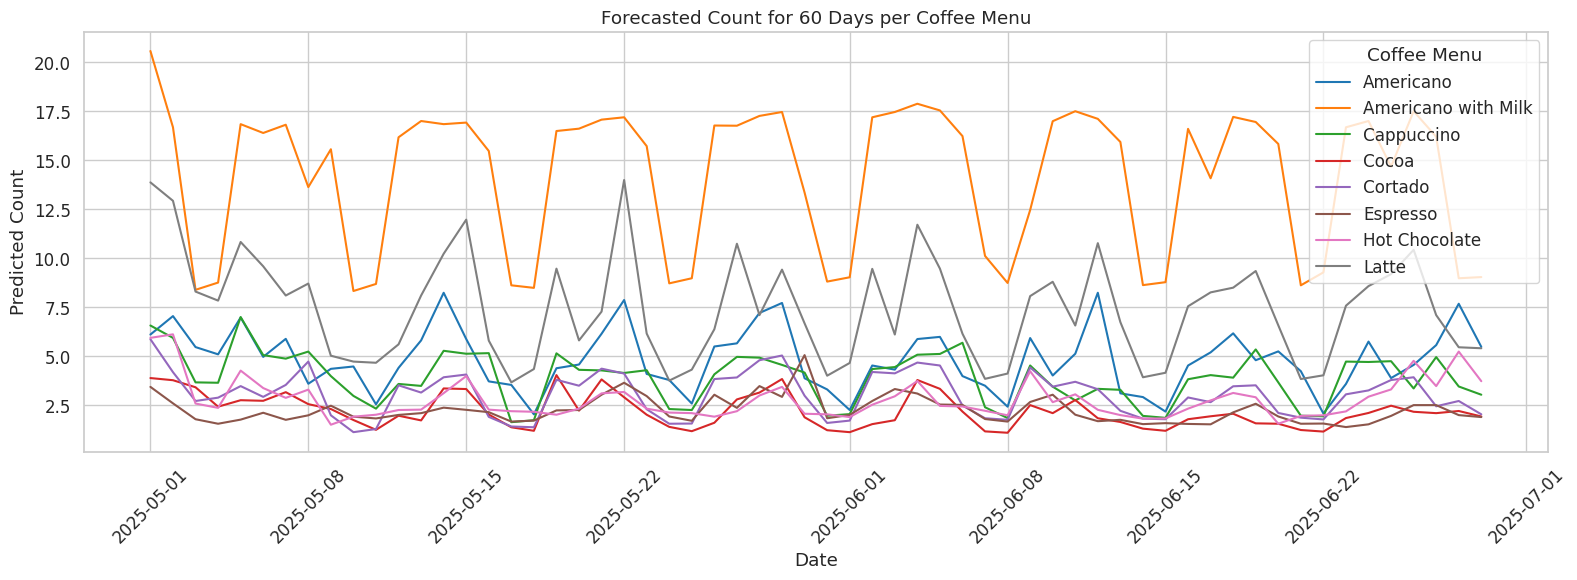

In [14]:
sns.set(style="whitegrid", palette="tab10", font_scale=1.1)

plt.figure(figsize=(16, 6))

# plot forecast ของทุกเมนู
for coffee in future_all['coffee_name'].unique():
    data = future_all[future_all['coffee_name'] == coffee]
    plt.plot(data['date'], data['predicted_count'], label=coffee)

plt.title("Forecasted Count for 60 Days per Coffee Menu")
plt.xlabel("Date")
plt.ylabel("Predicted Count")
plt.legend(title="Coffee Menu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# สร้าง pivot table: แถว=date, คอลัมน์=coffee_name, ค่า=predicted_count
forecast_table = future_all.pivot(index='date', columns='coffee_name', values='predicted_count')

# แสดง 20 แถวแรก
display(forecast_table.head(20))

coffee_name  Americano  Americano with Milk  Cappuccino  Cocoa  Cortado  \
date                                                                      
2025-05-01        6.11                20.57        6.57   3.89     5.87   
2025-05-02        7.05                16.68        5.94   3.78     4.19   
2025-05-03        5.47                 8.39        3.67   3.42     2.72   
2025-05-04        5.10                 8.76        3.65   2.43     2.89   
2025-05-05        6.98                16.84        7.00   2.76     3.48   
2025-05-06        4.97                16.39        5.06   2.73     2.93   
2025-05-07        5.89                16.81        4.88   3.17     3.54   
2025-05-08        3.60                13.63        5.24   2.56     4.73   
2025-05-09        4.36                15.56        3.99   2.31     1.99   
2025-05-10        4.48                 8.33        2.98   1.75     1.13   
2025-05-11        2.55                 8.69        2.33   1.25     1.29   
2025-05-12        4.41                16.17        3.59   1.97     3.52   
2025-05-13        5.81                17.00        3.49   1.73     3.15   
2025-05-14        8.24                16.84        5.28   3.36     3.93   
2025-05-15        5.88                16.92        5.13   3.33     4.07   
2025-05-16        3.72                15.47        5.16   2.03     1.91   
2025-05-17        3.54                 8.62        1.64   1.38     1.42   
2025-05-18        2.04                 8.49        1.74   1.20     1.38   
2025-05-19        4.39                16.49        5.15   4.04     3.80   
2025-05-20        4.58                16.61        4.31   2.23     3.50   

coffee_name  Espresso  Hot Chocolate  Latte  
date                                         
2025-05-01       3.44           5.94  13.87  
2025-05-02       2.60           6.12  12.93  
2025-05-03       1.79           2.59   8.30  
2025-05-04       1.56           2.37   7.84  
2025-05-05       1.77           4.27  10.83  
2025-05-06       2.12           3.38   9.59  
2025-05-07       1.76           2.88   8.10  
2025-05-08       1.99           3.30   8.71  
2025-05-09       2.48           1.51   5.03  
2025-05-10       1.92           1.92   4.73  
2025-05-11       1.83           2.02   4.67  
2025-05-12       2.01           2.26   5.61  
2025-05-13       2.10           2.28   8.10  
2025-05-14       2.38           3.12  10.23  
2025-05-15       2.27           3.99  11.97  
2025-05-16       2.15           2.28   5.80  
2025-05-17       1.67           2.20   3.67  
2025-05-18       1.72           2.17   4.35  
2025-05-19       2.24           2.02   9.47  
2025-05-20       2.26           2.33   5.81

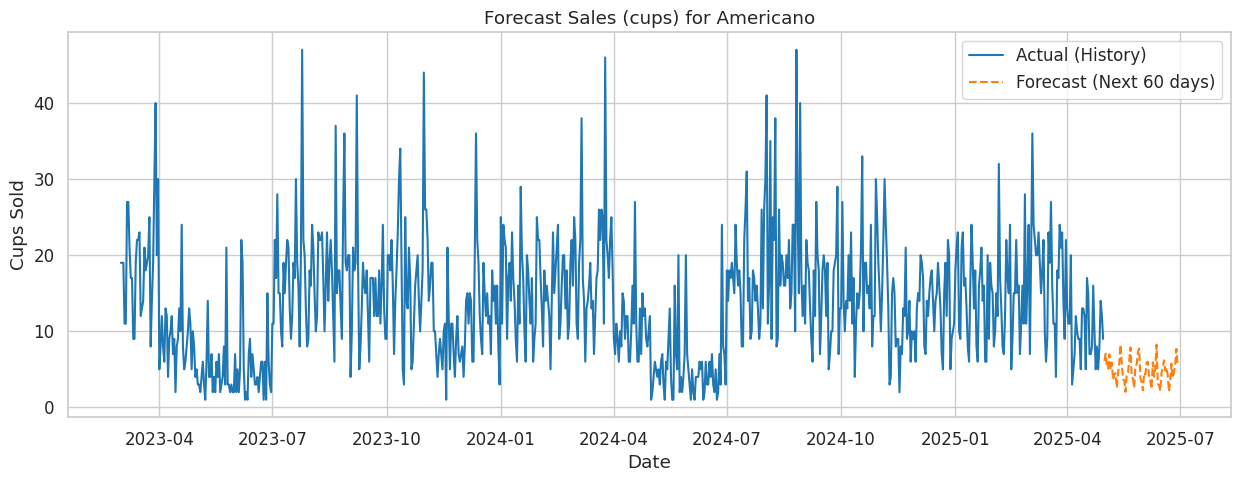

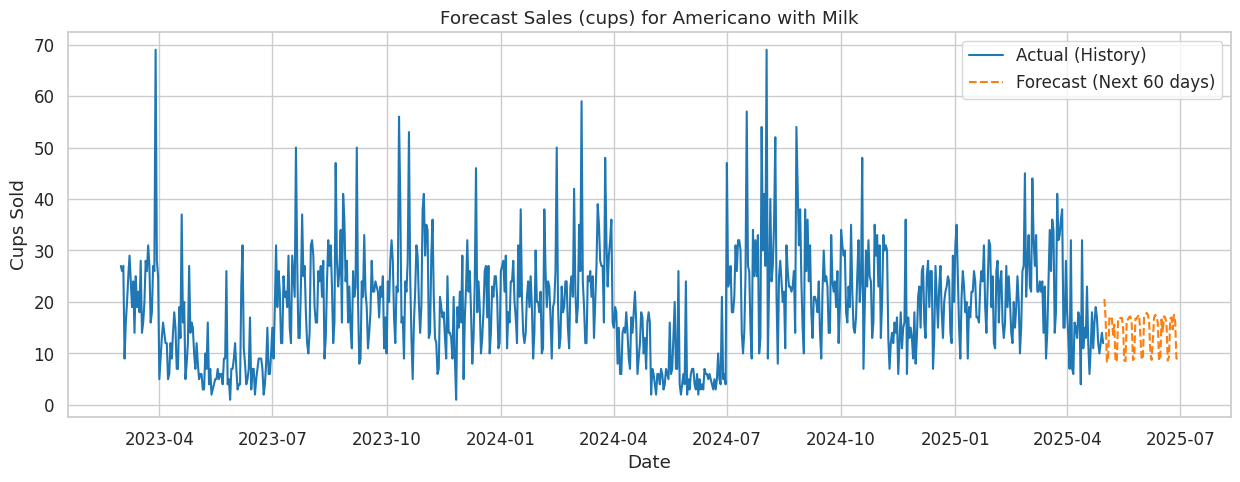

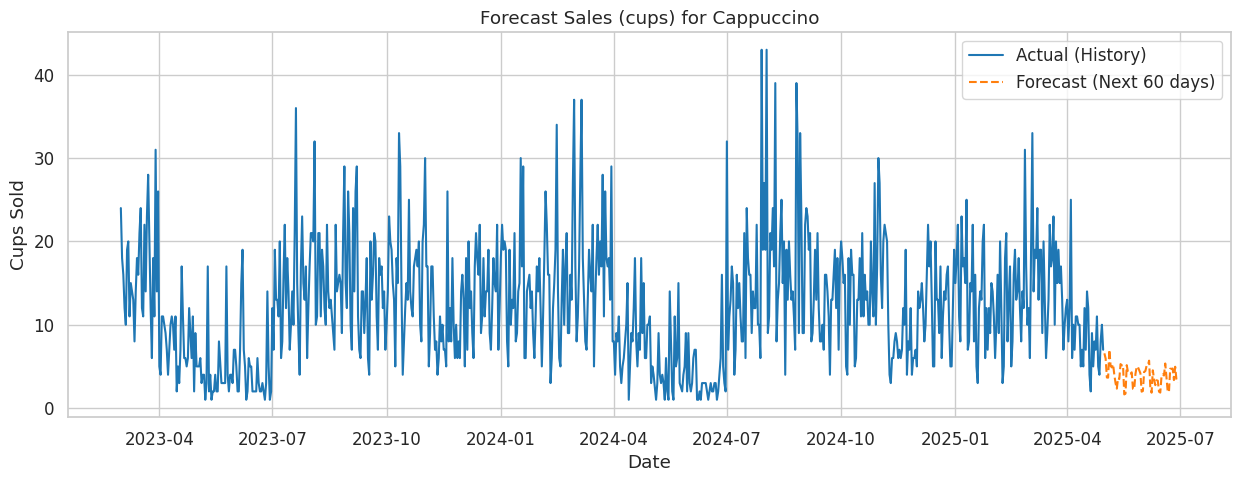

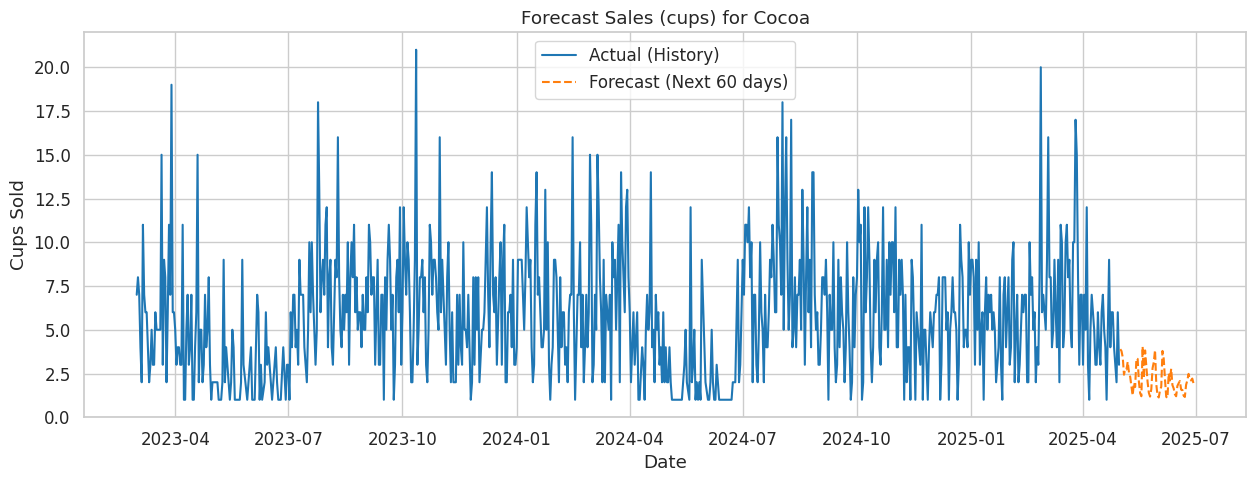

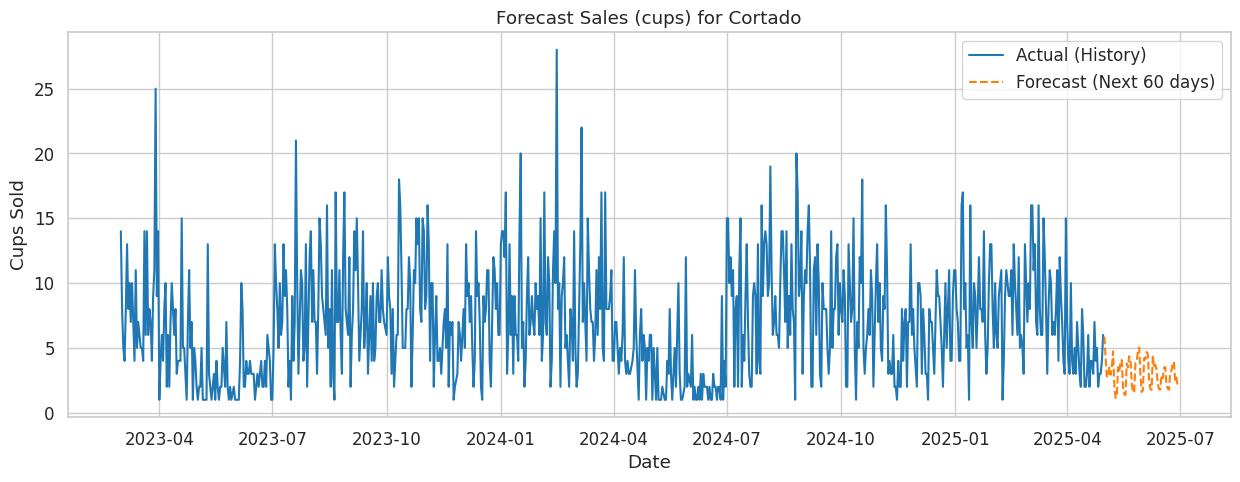

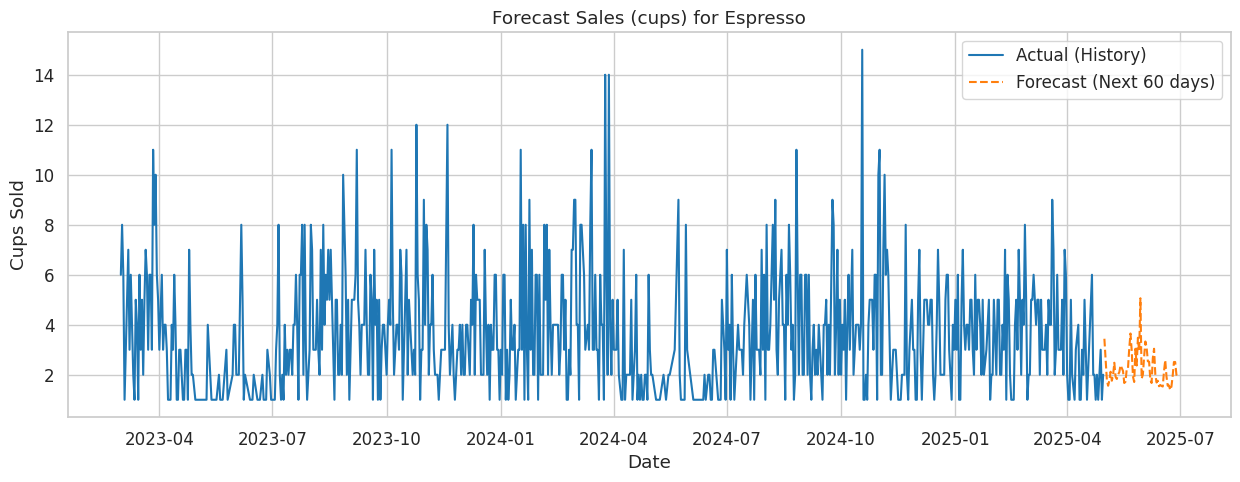

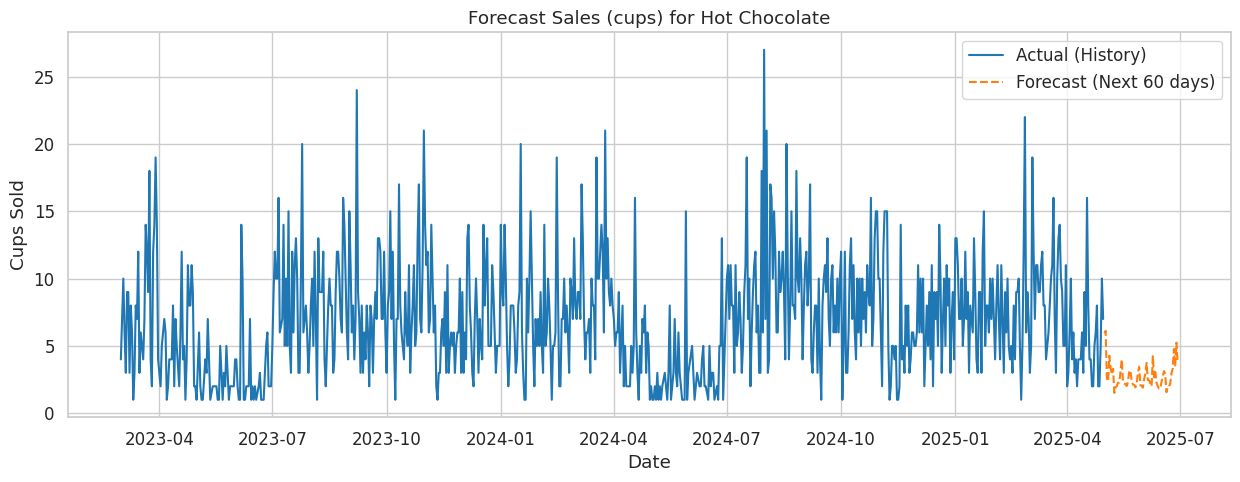

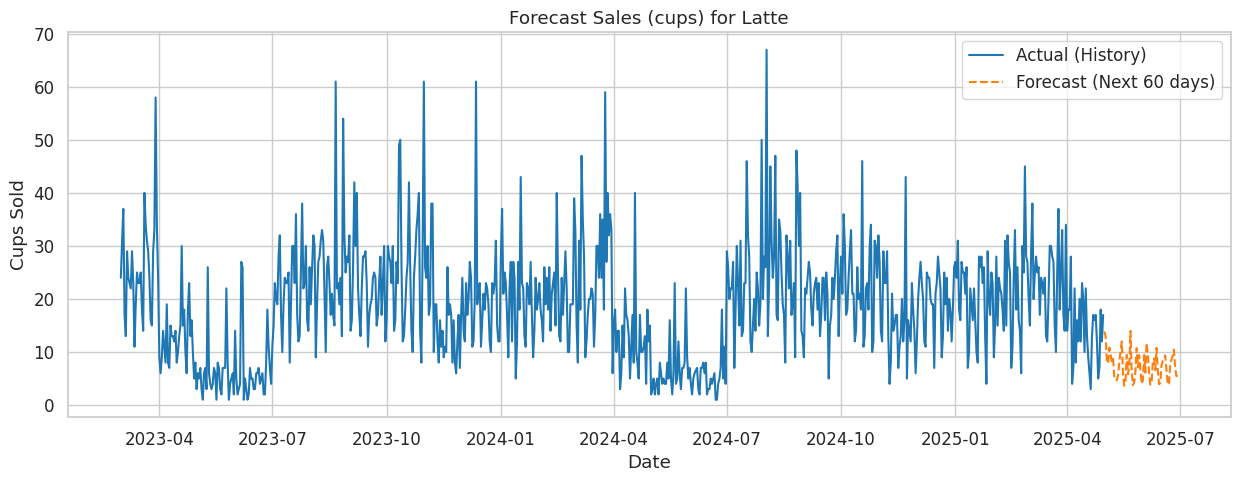

In [16]:
for coffee in daily_item_counts['coffee_name'].unique():
    plt.figure(figsize=(15, 5))
    history = daily_item_counts[daily_item_counts['coffee_name'] == coffee]
    future = future_all[future_all['coffee_name'] == coffee]

    plt.plot(history['date'], history['count'], label='Actual (History)')
    plt.plot(future['date'], future['predicted_count'], '--', label='Forecast (Next 60 days)')

    plt.title(f"Forecast Sales (cups) for {coffee}")
    plt.xlabel("Date")
    plt.ylabel("Cups Sold")
    plt.legend()
    plt.show()

RandomFores

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

XGBoost

In [31]:
# เตรียมข้อมูลสำหรับ train และ test
X_train, X_test = train[FEATURES], test[FEATURES]  # แยกฟีเจอร์สำหรับ train และ test
y_train, y_test = train[TARGET], test[TARGET]      # แยก target (ยอดขาย) สำหรับ train และ test

# สร้างโมเดล XGBoost Regression
xgb_model = xgb.XGBRegressor(
    n_estimators=100,    # จำนวน tree ที่สร้าง (100 ต้น)
    learning_rate=0.06,   # น้ำหนักของแต่ละ tree ในการปรับค่าผลรวม (ค่าต่ำ → เรียนรู้ช้า แต่แม่นยำขึ้น)
    max_depth=5,         # ความลึกสูงสุดของแต่ละ tree
    random_state=42      # กำหนด seed ให้ผลลัพธ์ reproducible
)

# Train โมเดล
xgb_model.fit(X_train, y_train)  # ให้โมเดลเรียนรู้ความสัมพันธ์ระหว่าง features และ target

# ประเมินผลบน Test Set
preds_test = model.predict(X_test)                  # ทำนายยอดขายจาก test set
mae = mean_absolute_error(y_test, preds_test)       # คำนวณ Mean Absolute Error (MAE)
print(f"MAE on Test Set: {mae:.2f}")               # แสดงค่า MAE เป็นตัวเลข 2 ตำแหน่ง

MAE on Test Set: 4.51


In [32]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [33]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [35]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} แก้ว")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 4.48 จากทั้งหมด 120 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 4.51 จากทั้งหมด 120 จุดข้อมูล
ยอดขายรวมใน Test Set: 2380.00 แก้ว


In [36]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test['date']

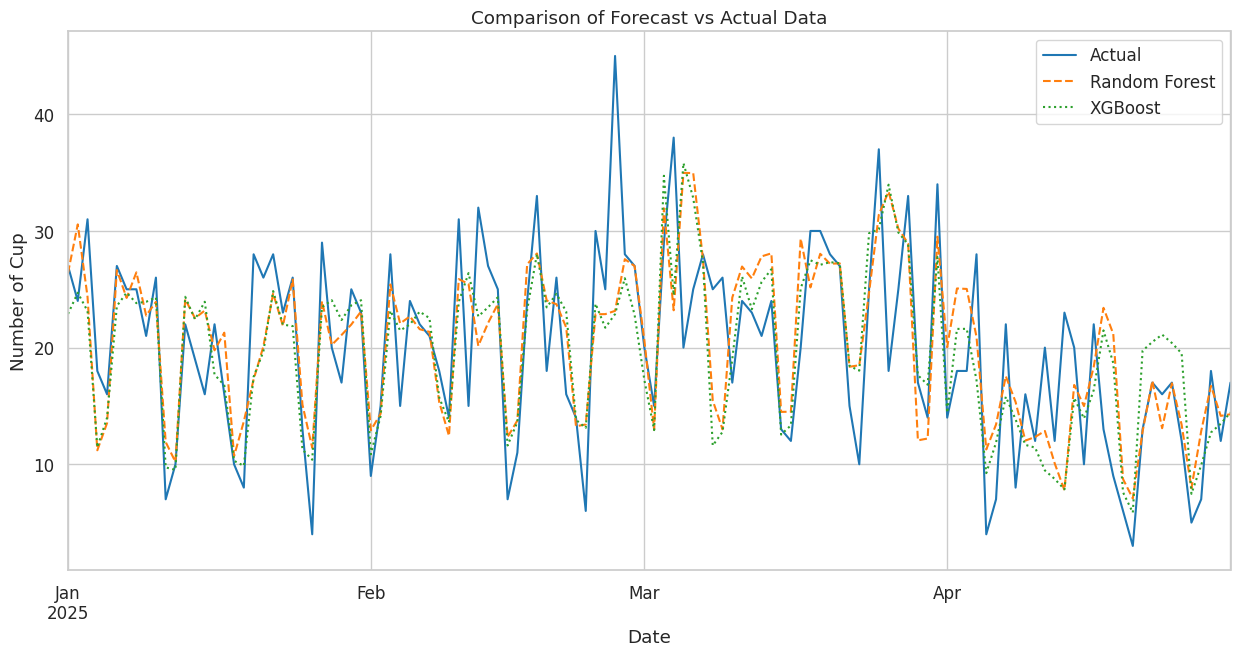

In [38]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Cup')
plt.xlabel('Date')
plt.legend()
plt.show()

In [40]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    # model.feature_importances_ → ค่า importance ของแต่ละ feature จาก model
    # index=features → ใช้ชื่อฟีเจอร์เป็น index
    # columns=['importance'] → ตั้งชื่อคอลัมน์เป็น 'importance'
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])

    # จัดเรียง feature ตามค่า importance จากมากไปน้อย
    fi_sorted = fi.sort_values('importance', ascending=False)

    # -----------------------------
    # สร้างกราฟ bar plot
    # -----------------------------
    plt.figure(figsize=(10, 6))  # กำหนดขนาดกราฟ
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])  # plot ค่า importance

    # ตั้งชื่อกราฟ
    plt.title(f'Feature Importance of the {model_name} Model')  # ชื่อกราฟเป็นภาษาอังกฤษ
    plt.xticks(rotation=45)  # หมุนชื่อฟีเจอร์ 45 องศาให้อ่านง่าย
    plt.xlabel('Features')   # ใส่ label แกน x

    plt.show()  # แสดงกราฟ


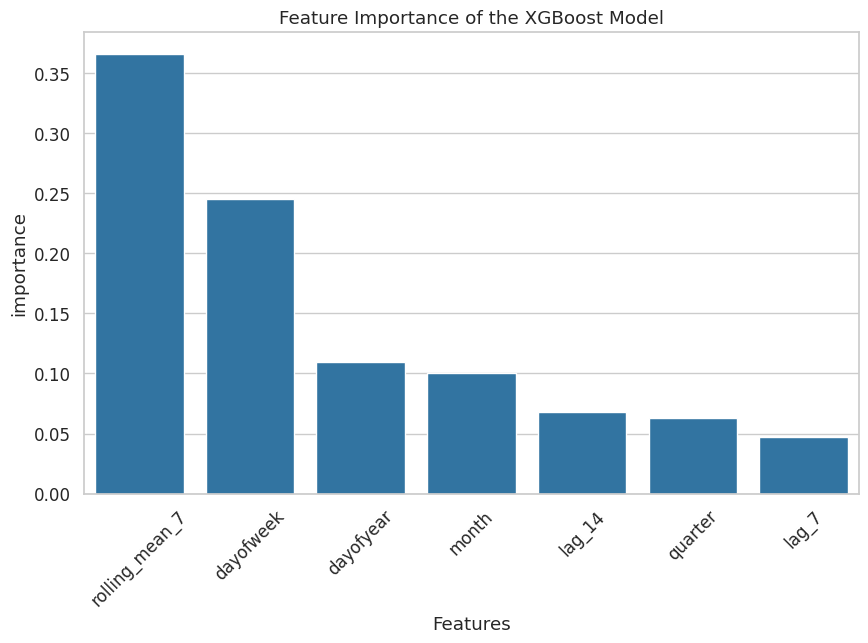

In [41]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

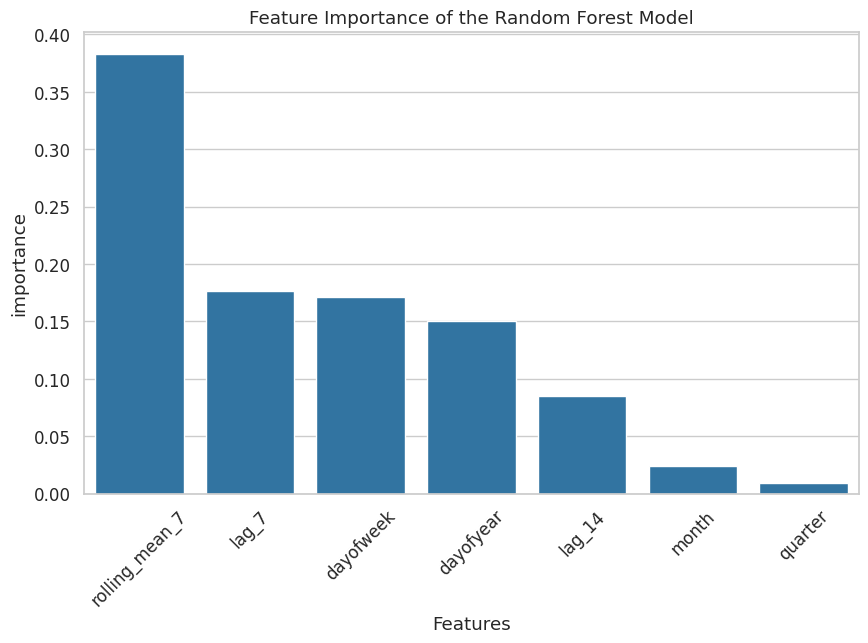

In [42]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [77]:
prophet_preds = {}

for coffee in daily_item_counts['coffee_name'].unique():
    coffee_data = daily_item_counts[daily_item_counts['coffee_name'] == coffee].copy()

    if coffee_data.empty:
        print(f"No data for {coffee}, skipping.")
        continue  # ข้ามเมนูถ้าไม่มีข้อมูล

    # สร้าง df สำหรับ Prophet
    df_prophet = coffee_data[['date', 'count']].rename(columns={'date':'ds','count':'y'})

    # สร้างโมเดล Prophet
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(df_prophet)

    # Forecast 60 วัน
    future = model.make_future_dataframe(periods=60)
    forecast = model.predict(future)

# -----------------------------
# เก็บผลลัพธ์ forecast ของ Prophet
# -----------------------------
forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# เลือกเฉพาะคอลัมน์สำคัญ
# ds          = วันที่
# yhat        = predicted value
# yhat_lower  = lower bound ของ prediction (confidence interval)
# yhat_upper  = upper bound ของ prediction (confidence interval)

forecast_result['coffee_name'] = coffee
# เพิ่มคอลัมน์ชื่อเมนูกาแฟ เพื่อแยกผลลัพธ์สำหรับแต่ละเมนู

prophet_preds[coffee] = forecast_result
# เก็บ DataFrame ของเมนูนี้ลงใน dictionary prophet_preds
# key = ชื่อกาแฟ, value = forecast DataFrame


# ตรวจสอบ
print(prophet_preds.keys())

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/_lb78_zm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/5jki641_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11988', 'data', 'file=/tmp/tmp7q50tx48/_lb78_zm.json', 'init=/tmp/tmp7q50tx48/5jki641_.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_model6heiuk15/prophet_model-20250921133817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:38:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:38:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/y04mpkfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/k4ae4sq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

dict_keys(['Latte'])


/tmp/ipython-input-1080416859.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result['coffee_name'] = coffee


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/req75w6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/l4rvqata.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80670', 'data', 'file=/tmp/tmp7q50tx48/req75w6p.json', 'init=/tmp/tmp7q50tx48/l4rvqata.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_modelklv6f439/prophet_model-20250921134228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


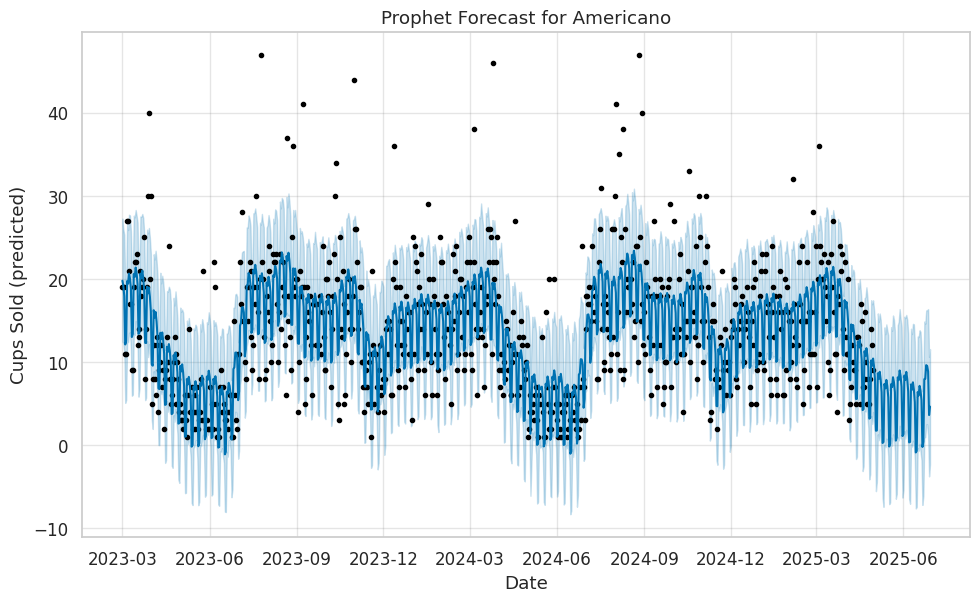

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/71wd6u1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/22icy4m4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1636', 'data', 'file=/tmp/tmp7q50tx48/71wd6u1i.json', 'init=/tmp/tmp7q50tx48/22icy4m4.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_modeld6y2obtg/prophet_model-20250921134230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


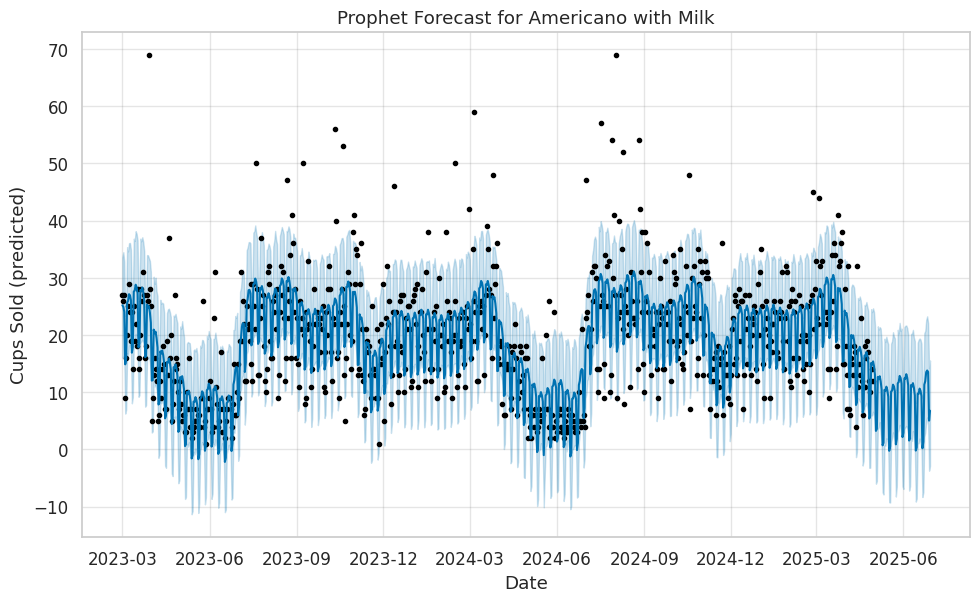

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/z9af2ker.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/_o0bcr8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78583', 'data', 'file=/tmp/tmp7q50tx48/z9af2ker.json', 'init=/tmp/tmp7q50tx48/_o0bcr8n.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_model5zgv3xvn/prophet_model-20250921134230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


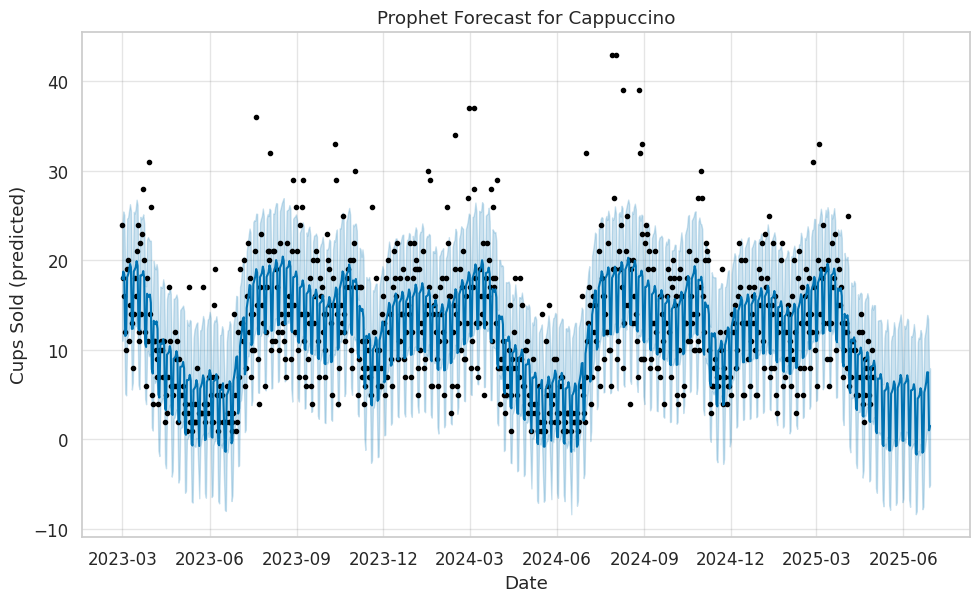

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/j7mk36oq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/ofon58py.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97802', 'data', 'file=/tmp/tmp7q50tx48/j7mk36oq.json', 'init=/tmp/tmp7q50tx48/ofon58py.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_modelhmgr6do1/prophet_model-20250921134231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


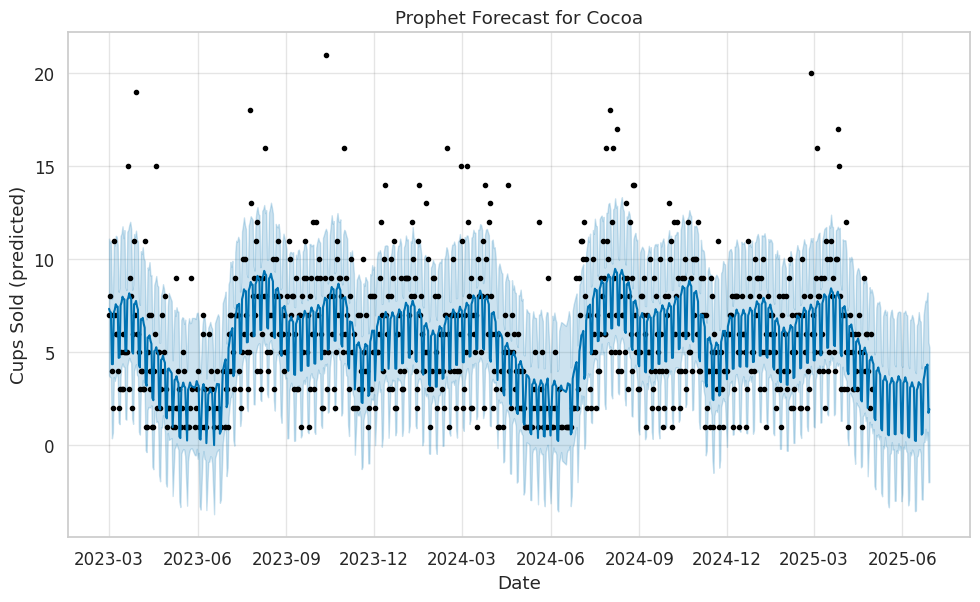

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/jvmgr34q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/aum0sj9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20228', 'data', 'file=/tmp/tmp7q50tx48/jvmgr34q.json', 'init=/tmp/tmp7q50tx48/aum0sj9i.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_modelf8gymhi2/prophet_model-20250921134232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


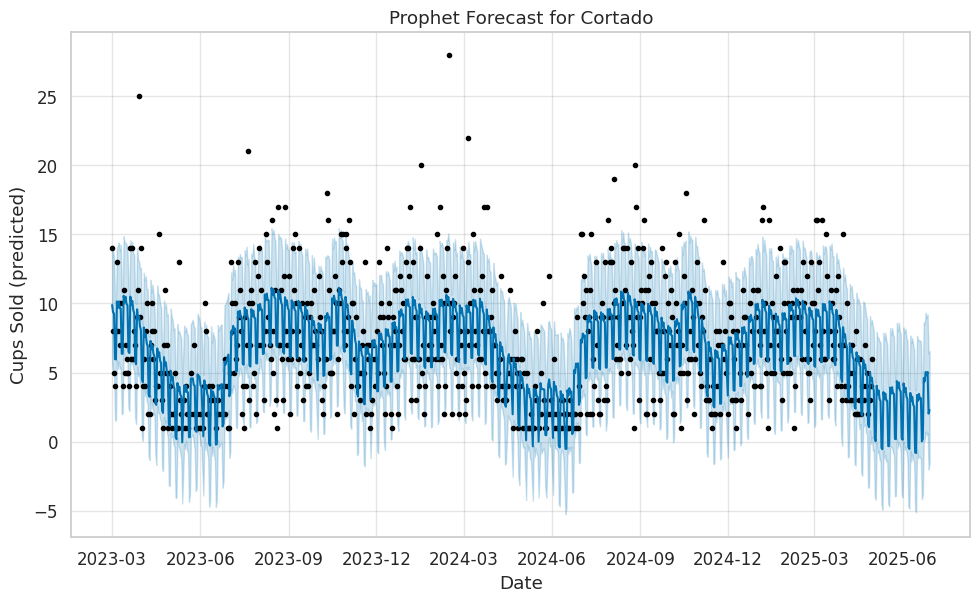

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/82ttg3zy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/h599gotx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47524', 'data', 'file=/tmp/tmp7q50tx48/82ttg3zy.json', 'init=/tmp/tmp7q50tx48/h599gotx.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_modelt6ffm6qt/prophet_model-20250921134232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


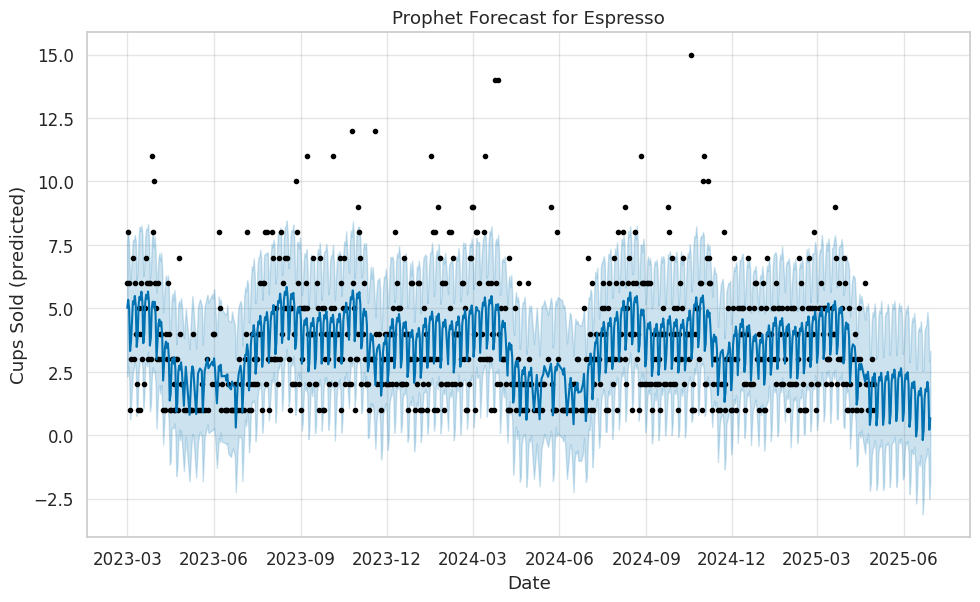

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/rnsyaljl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/a5b77y2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84440', 'data', 'file=/tmp/tmp7q50tx48/rnsyaljl.json', 'init=/tmp/tmp7q50tx48/a5b77y2w.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_modelfq6j_1hj/prophet_model-20250921134233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


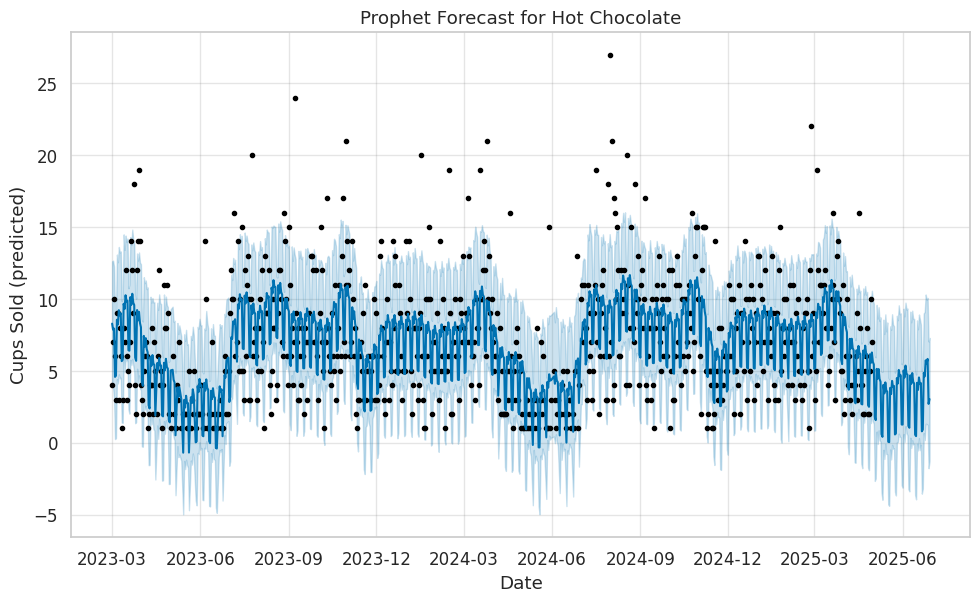

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/wx9rwjj_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7q50tx48/6uy0zus4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10257', 'data', 'file=/tmp/tmp7q50tx48/wx9rwjj_.json', 'init=/tmp/tmp7q50tx48/6uy0zus4.json', 'output', 'file=/tmp/tmp7q50tx48/prophet_modelvr57ocz5/prophet_model-20250921134234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


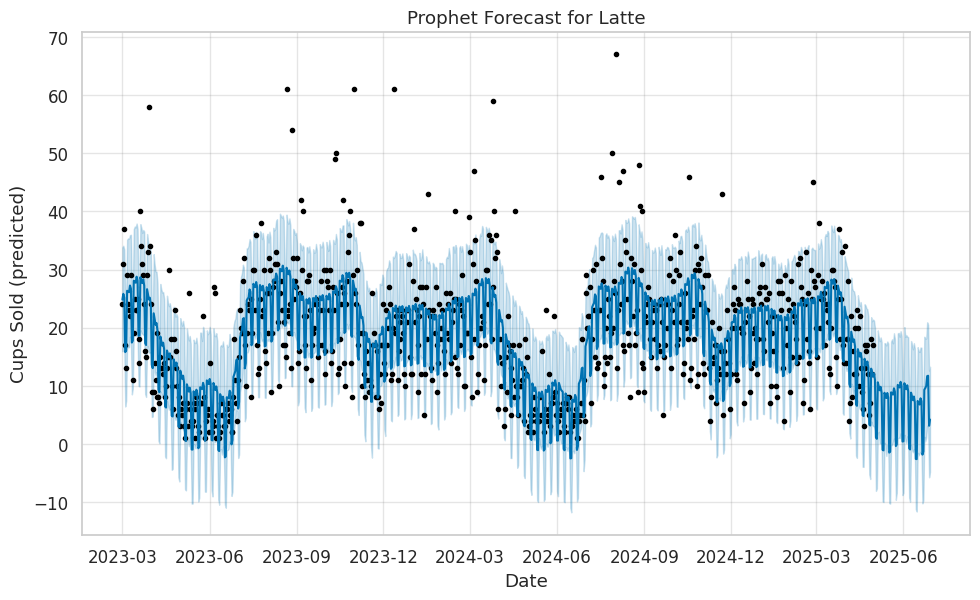

In [88]:
# วนลูปผ่านชื่อเมนูกาแฟทั้งหมดในข้อมูล
for coffee in daily_item_counts['coffee_name'].unique():
    # เลือกเฉพาะข้อมูลของเมนูนี้และสร้างสำเนา
    coffee_data = daily_item_counts[daily_item_counts['coffee_name'] == coffee].copy()

    # ถ้าไม่มีข้อมูลสำหรับเมนูนี้ ข้ามไปเมนูถัดไป
    if coffee_data.empty:
        continue

    # เตรียม DataFrame สำหรับ Prophet: rename columns เป็น ds (date) และ y (target)
    df_prophet = coffee_data[['date','count']].rename(columns={'date':'ds','count':'y'}).copy()

    # สร้างโมเดล Prophet พร้อม seasonality
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

    # ฝึกโมเดลกับข้อมูลของเมนูนี้
    model.fit(df_prophet)

    # สร้าง DataFrame สำหรับทำนายล่วงหน้า 60 วัน
    future = model.make_future_dataframe(periods=60)

    # ทำนาย forecast
    forecast = model.predict(future)

    # เก็บผลลัพธ์สำคัญ (yhat, ช่วง confidence interval) และเพิ่มชื่อเมนู
    forecast_result = forecast[['ds','yhat','yhat_lower','yhat_upper']].copy()
    forecast_result['coffee_name'] = coffee

    # เก็บผลลัพธ์ลง dictionary โดยใช้ชื่อเมนูเป็น key
    prophet_preds[coffee] = forecast_result

    # -----------------------------
    # Plot forecast ของ Prophet สำหรับเมนูนี้
    # -----------------------------
    fig = model.plot(forecast)                     # วาดกราฟ trend + confidence interval
    plt.title(f"Prophet Forecast for {coffee}")   # ตั้งชื่อกราฟ
    plt.xlabel("Date")                             # label แกน x
    plt.ylabel("Cups Sold (predicted)")           # label แกน y
    plt.show()

In [90]:
# -----------------------------
# รวมผลลัพธ์ forecast ของทุกเมนู
# -----------------------------
# prophet_preds เป็น dictionary: key = ชื่อเมนู, value = forecast DataFrame
prophet_all = pd.concat(prophet_preds.values(), ignore_index=True)

# แสดงข้อมูลตัวอย่าง 200 แถวท้าย
display(prophet_all.tail(200))

ds      yhat  yhat_lower  yhat_upper    coffee_name
6451 2024-12-11  9.232881    5.099926   13.722685  Hot Chocolate
6452 2024-12-12  8.767060    4.594014   12.859663  Hot Chocolate
6453 2024-12-13  8.776877    4.128590   12.936663  Hot Chocolate
6454 2024-12-14  5.310232    0.903876    9.514627  Hot Chocolate
6455 2024-12-15  5.270484    1.159240    9.550420  Hot Chocolate
...         ...       ...         ...         ...            ...
6646 2025-06-25  5.727741    1.313235   10.308445  Hot Chocolate
6647 2025-06-26  5.517275    1.289542    9.963417  Hot Chocolate
6648 2025-06-27  5.826780    1.243954   10.070028  Hot Chocolate
6649 2025-06-28  2.698342   -1.777466    7.037169  Hot Chocolate
6650 2025-06-29  3.028583   -1.305014    7.289055  Hot Chocolate

[200 rows x 5 columns]

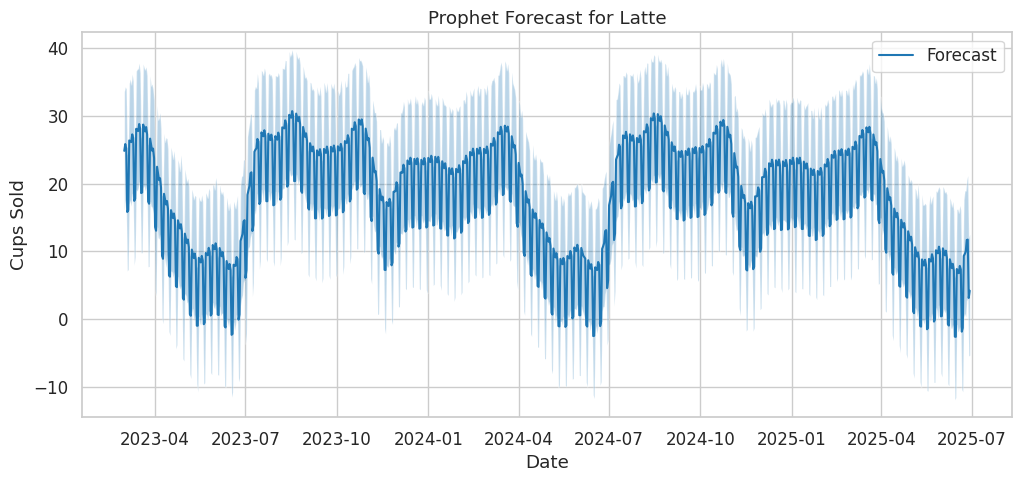

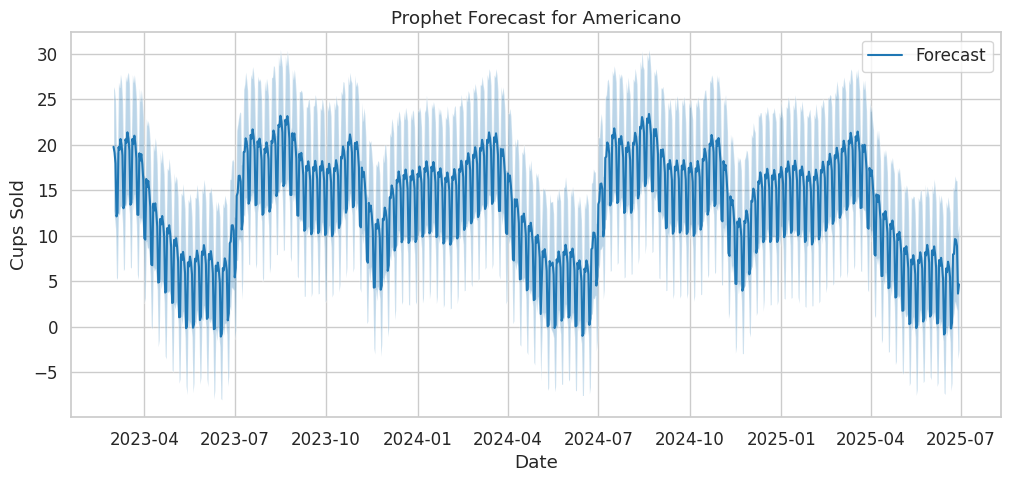

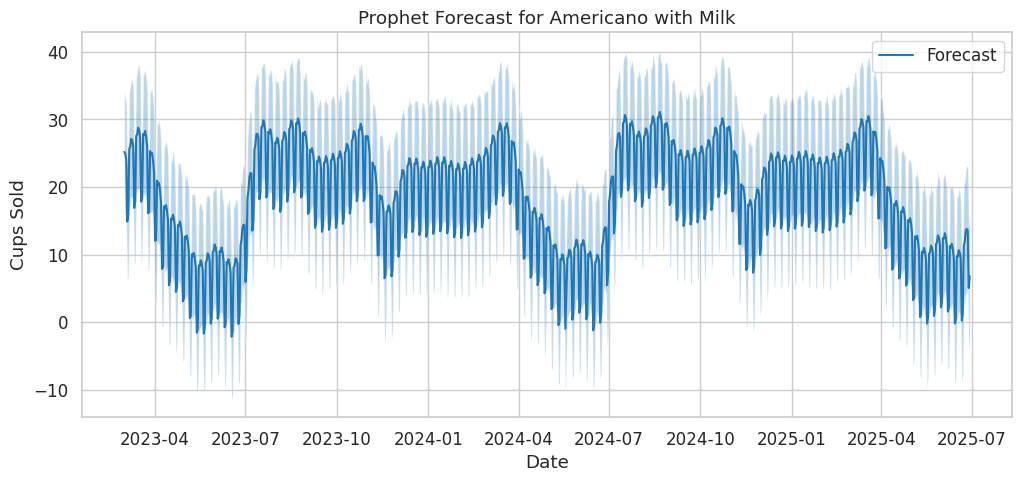

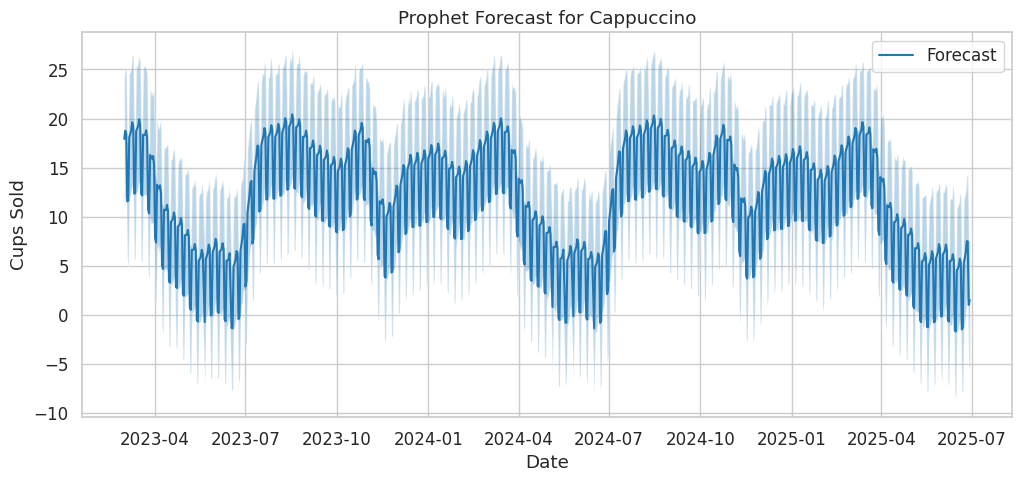

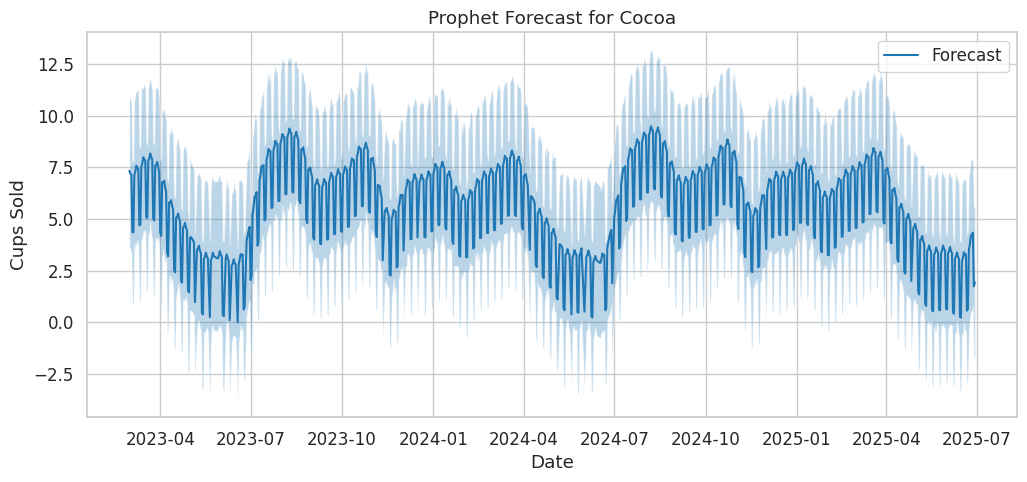

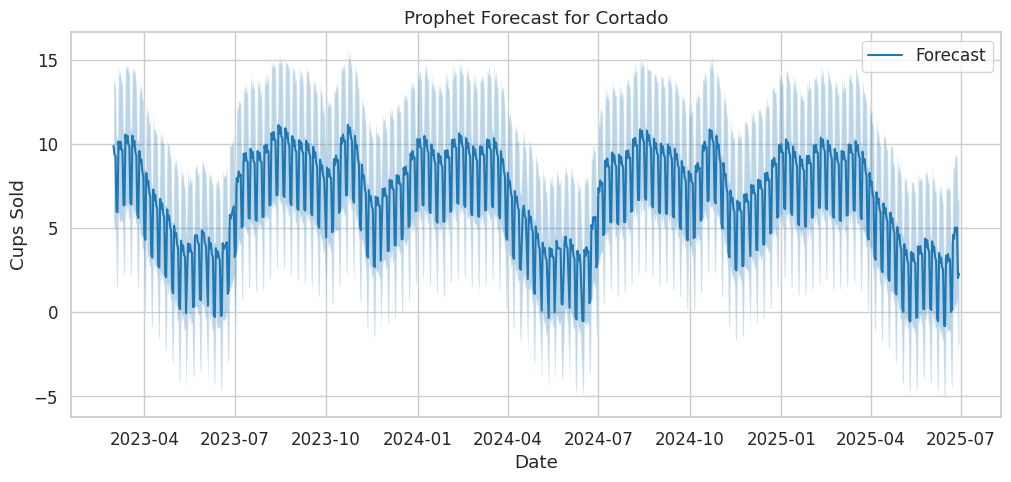

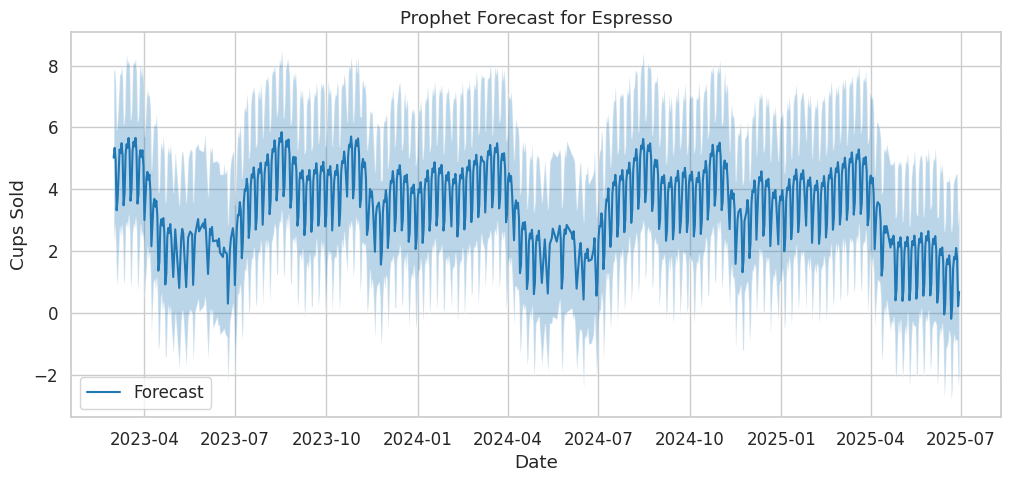

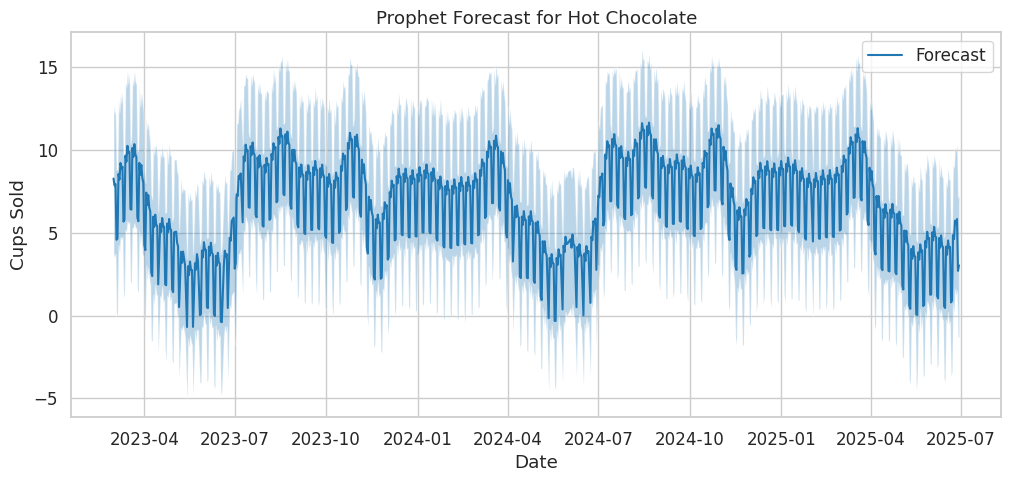

In [89]:
for coffee in prophet_all['coffee_name'].unique():
    df = prophet_all[prophet_all['coffee_name'] == coffee]
    plt.figure(figsize=(12,5))
    plt.plot(df['ds'], df['yhat'], label='Forecast')
    plt.fill_between(df['ds'], df['yhat_lower'], df['yhat_upper'], alpha=0.3)
    plt.title(f'Prophet Forecast for {coffee}')
    plt.xlabel('Date')
    plt.ylabel('Cups Sold')
    plt.legend()
    plt.show()
